# Entrenamiento

Se busca predecir la personalidad del autor de un texto, es decir, se usa texto como entrada y la salida es una de las 16 personalidades de Myers-Briggs.

Lo primero es cargar el dataset usando Pandas, este contiene solo dos columnas, personalidad y post que corresponden a la personalidad y el contenido de un post de X.

# Preprocesado

Aquí partimos del preprocesado anterior (Stopwords, Tokenización y Stemming), seleccionamos una parte del dataset para usarlo para entrenamiento y test, se hace la reducción de dimensionalidad a 2000 componentes y se hace la bolsa de palabras

In [1]:
import joblib as jb

preprocessedData = jb.load("preprocessed_data.lzma")
preprocessedData = preprocessedData.head(25_000)

print(preprocessedData.value_counts())

personality  processed_text                                         
7                                                                       415
4                                                                       300
12                                                                      297
8                                                                       270
3                                                                       215
                                                                       ... 
7            bruhbmi couson wouldbt lesv alon ab eat                      1
             bruh thought place miss lmao misunderstoond sec              1
             bruh ok liter racist r u defend                              1
             bruh miss much fuck need get probabl got foreverrrr ago      1
16           yusss                                                        1
Length: 22140, dtype: int64


División en datos de entrenamiento y test.

In [2]:
from sklearn.model_selection import train_test_split

X = preprocessedData['processed_text']
Y = preprocessedData['personality']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

Creación de la bolsa de palabras

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Datos de entrenamiento
bagOfWordsModel = TfidfVectorizer()
X_train = bagOfWordsModel.fit_transform(X_train)
print("X_train bag of words:")
print(X_train.shape)

# Datos pruebas
X_test = bagOfWordsModel.transform(X_test)
print("X_test bag of words:")
print(X_test.shape)

X_train bag of words:
(20000, 15507)
X_test bag of words:
(5000, 15507)


Reducción de dimensionalidad

In [4]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5000, random_state=42)
X_train = svd.fit_transform(X_train)

print(X_train.shape)

(20000, 5000)


In [5]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       X_train: 762.9 MiB
              preprocessedData:  2.2 MiB
                             X:  2.0 MiB
                       y_train: 312.5 KiB
                             Y: 195.5 KiB
                        y_test: 78.1 KiB
               TfidfVectorizer:  2.0 KiB
                  TruncatedSVD:  1.4 KiB
                           _i5:  595.0 B
                           _ii:  381.0 B


In [6]:
jb.dump(svd, "svd.lzma")
del svd
del preprocessedData, X, Y, TfidfVectorizer, TruncatedSVD

In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'max_leaf_nodes': [15, 31, 50]
}

rfc = HistGradientBoostingClassifier()
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

rfc = HistGradientBoostingClassifier(**best_params)
rfc.fit(X_train, y_train)

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 300, 'max_leaf_nodes': 50}


HistGradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_iter=300,
                               max_leaf_nodes=50)

In [8]:
svd = jb.load("svd.lzma")
X_test = svd.transform(X_test)

              precision    recall  f1-score   support

           3       0.49      0.08      0.13       562
           4       0.35      0.41      0.38      1012
           7       0.30      0.68      0.41      1188
           8       0.39      0.14      0.21       878
          12       0.35      0.23      0.28       945
          15       0.20      0.01      0.02       105
          16       0.36      0.03      0.05       310

    accuracy                           0.32      5000
   macro avg       0.35      0.23      0.21      5000
weighted avg       0.36      0.32      0.28      5000



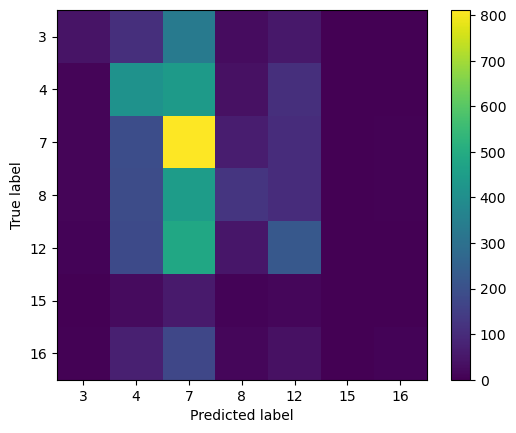

In [9]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions,
                                        include_values=False)
plt.show()

In [10]:
import os
import random
from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_file(f"mammamia/{random.choice(os.listdir('mammamia'))}")
play(song)

Input #0, wav, from '/tmp/tmp3m3t5sgu.wav':   0KB sq=    0B f=0/0   
  Duration: 00:04:57.96, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s
